In [48]:
import pandas as pd
import numpy as np
import re #text temizleme
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
#NLTK veri indirme
nltk.download('stopwords')
nltk.download('punkt')

#Versiyon kontrolu
print("Pandas: ", pd.__version__)
print("NumPy: ",np.__version__)
print("NLTK: ", nltk.__version__)

Pandas:  2.3.2
NumPy:  1.26.4
NLTK:  3.8.1


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mat76\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mat76\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [50]:
#Veriyi oku
df = pd.read_csv('spam.csv', encoding='latin-1')

In [51]:
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [52]:
df.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [53]:
df.isnull().sum()
#Unnamed:2 , Unnamed:3, Unnamed:4 sutunlarinda cok az veri mevcut

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [54]:
df = df[['v1' , 'v2']].copy() #sadece gerekli sutunlari tutuyoruz
df.columns = ['case' , 'message'] #sutunlara anlasilabilir isimlendirme
df.loc[:,'case'] = df['case'].map({'ham' :0 , 'spam' : 1}) # 0-1 durum atamasi
df= df.dropna( subset = ['case']) #Nan etiketleri sil
df.loc[: , 'case'] = df['case'].astype(int) #integer turune cevir
print("Etiketlerin degerleri:", df['case'].value_counts())
print("Etiketlerin veri tipi: ", df['case'].dtype)

Etiketlerin degerleri: case
0    4825
1     747
Name: count, dtype: int64
Etiketlerin veri tipi:  object


In [55]:
df

,case,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [56]:
df['case'].value_counts()

case
0    4825
1     747
Name: count, dtype: int64

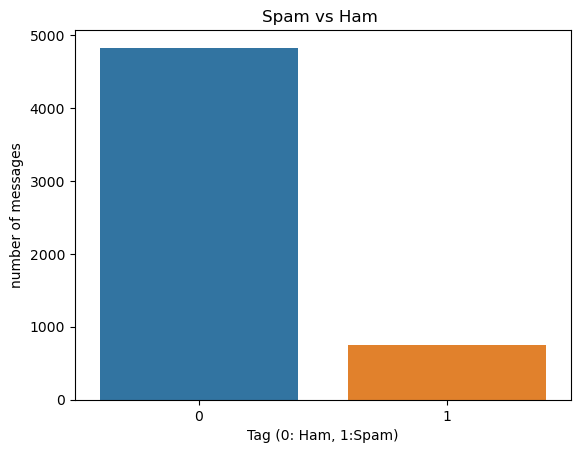

In [57]:
#spam durumunu (0-1) gorsellestir
sns.countplot(x='case', data=df)
plt.title('Spam vs Ham ')
plt.xlabel('Tag (0: Ham, 1:Spam)')
plt.ylabel('number of messages')
plt.show()

In [58]:
#Text on isleme ve model egitme
 
#Stemmer ve stopwords

#Bilgi -> stopwords: İngilizce’de çok sık geçen ama anlam katmayan kelimeler
#(the, is, at, of, and, …). Bunları çıkartacagiz

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english')) #kelimeleri kok haline indir (running -> run)

#Temizleme fonksiyonu
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text) #harf ve bosluk disinda her seyi sil
    words = nltk.word_tokenize(text) #kelimelere ayir
    
    #mesajdaki her kelimeyi al stopwords yoksa islem yap, kelimeyi kokune indir (stem'le)
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(words) #temizlenen kelimeleri tekrar birlestir

#Mesajlari temizle
df.loc[:,'cleaned_message'] = df['message'].apply(clean_text)
df.head()

,case,message,cleaned_message
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkt st m...
3,0,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah dont think goe usf live around though


y_train veri tipi: int32
y_test veri tipi: int32
Dogruluk: 97.67%
              precision    recall  f1-score   support

         Ham       0.97      1.00      0.99       965
        Spam       1.00      0.83      0.91       150

    accuracy                           0.98      1115
   macro avg       0.99      0.91      0.95      1115
weighted avg       0.98      0.98      0.98      1115



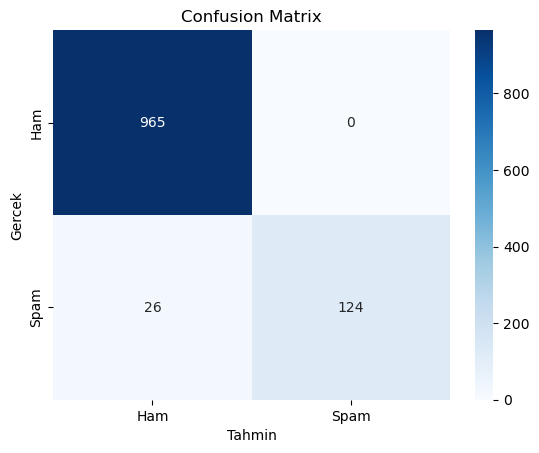

In [59]:
#Modeli Egitme
#TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features = 3000)
X = vectorizer.fit_transform(df['cleaned_message']).toarray()
y= df['case']
    
#Train/test split
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train = y_train.astype(int)
y_test = y_test.astype(int)

#veri tipi kontrol
print("y_train veri tipi:", y_train.dtype)
print("y_test veri tipi:", y_test.dtype)

#Naive Bayes modeli
model = MultinomialNB()
model.fit(X_train, y_train)

#Tahmin ve degerlendirme
y_pred= model.predict(X_test)
print(f'Dogruluk: {accuracy_score(y_test, y_pred)* 100:.2f}%')
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

#Confusion matrix
cm= confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham','Spam'], yticklabels=['Ham','Spam'])
plt.title('Confusion Matrix')
plt.xlabel('Tahmin')
plt.ylabel('Gercek')
plt.show()